In [1]:
#!/opt/conda/envs/lae2020/bin/python3

from importlib.abc import Loader
import sys
import os
import ruamel.yaml

sys.path.insert(0,"/home/chinahg/GCresearch/cantera/build/python")
sys.path.insert(1,"/home/chinahg/GCresearch/rocketemissions")

import cantera as ct
ct.add_directory('/user/chinahg')
ct.__file__

import h5py
import numpy as np
import time
import math as math
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import yaml
import shutil
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
#ZEF
def dBdx(t,B): #(x,B_star)
   beta_s = 0.154
   U_s = abs((-1 + np.sqrt(1 - 4/(-np.pi*B**2))/2))
   fB = beta_s*(U_s/(U_s + 1))
   return fB

def diffusion(nx, nr, xmax, rmax, nT, T_a):
   """
   Returns the velocity field and distance for 1D linear convection
   """
   # Increments
   dx = xmax/(nx-1)
   dr = rmax/(nr-1)

   # Initialise data structures
   import numpy as np
   T = np.zeros((nr,nx))
   r = np.zeros(nr)

   # Boundary conditions
   T[0,:] = T[nr-1,:] = T_a

   # X Loop
   for i in range(0,nr):
      r[i] = i*dr
    
   # Initial conditions
   for i in range(1,nr-1):
      if(r[i-1] + dr > (rmax/2)-1.45 and r[i-1] + dr < (rmax/2)+1.45):
         T[i,0] = 1500
      else:
         T[i,0] = T_a

   # Loop
   for n in range(0,nx-1):
      for i in range(0,nr-1):
         T[i,n+1] = T[i,n] + nT*(dx/dr**2.0)*(T[i+1,n]-2.0*T[i,n]+T[i-1,n])

   return T, r

def plot_diffusion(T,r,nx,xmax,title):
   """
   Plots the 1D velocity field
   """

   import matplotlib.pyplot as plt
   import matplotlib.cm as cm
   plt.figure()
   colour=iter(cm.rainbow(np.linspace(0,xmax,nx)))
   for i in range(0,nx):
      c=next(colour)
      plt.plot(r-100,T[:,i],c=c)
   plt.xlabel('r (m)')
   plt.ylabel('T (K)')
   plt.title(title)
   plt.show()
    
#def sigma(s,r,u):
#    return (1/s)*np.exp(-0.5*r**2/s**2) - u*np.sqrt(2*np.pi)



In [3]:
D = 2.90 # m initial plume diameter
U_a = 428 #ambient velocity (need to import)
xmax_ZEF = 100 # m
xmax_ZFE = 6.2*D
xmax = xmax_ZFE + xmax_ZEF # m total domain (including ZFE)

nx_ZEF = 100
nx_ZFE = 100
nr = 1000

u = np.zeros((nx_ZEF+nx_ZFE,nr))
c = np.zeros((nx_ZEF+nx_ZFE,nr))
u_ZFE0 = 1500 #rocket velocity (need to import)
c_ZFE0 = 600000 #tracer ppm test
beta_ZFE = 0.114
lmbda_ZFE = 1.2

b = np.zeros(nx_ZFE) #plume radius
R = np.zeros(nx_ZFE) #core radius
r_ZFE = np.zeros((nx_ZFE,nr)) #radial sampling points, for each x. For x = 1 sample points from r = 0 to r = b[i]

x_ZFE = np.linspace(0,xmax_ZFE,nx_ZFE)
x_ZEF = np.linspace(0,xmax_ZEF,nx_ZEF)
sigma_ZFEu = np.zeros(nx_ZFE)
sigma_ZFEc = np.zeros(nx_ZFE)

A_u_sq = np.zeros(nx_ZFE)
A_c_sq = np.zeros(nx_ZFE)
A_c = c_ZFE0*(D/2) #step fxn area
A_u = u_ZFE0*(D/2) #step fxn area

#ZFE
#u[x,r], c[x,r]
for i in range(0,nx_ZFE):
    b[i] = beta_ZFE*x_ZFE[i] + (D/2)
    r_ZFE[i,:] = np.linspace(0,10,nr)
    R[i] = x_ZFE[i]*(-D/2)/xmax_ZFE + (D/2)  #core width fxn (y = mx + b)
    
    A_u_sq[i] = R[i]*u_ZFE0 #rectangular area
    A_c_sq[i] = R[i]*c_ZFE0

    sigma_ZFEu[i] = 2*(A_u-A_u_sq[i])/(u_ZFE0*np.sqrt(2*np.pi)) #WHERE FROM????
    sigma_ZFEc[i] = 2.35*(A_c-A_c_sq[i])/(c_ZFE0*np.sqrt(2*np.pi))

    for j in range(0,nr):
        if r_ZFE[i,j] < R[i]:
            u[i,j] = u_ZFE0
            c[i,j] = c_ZFE0
        else:
            u[i,j] = u_ZFE0*np.exp((-(r_ZFE[i,j]-R[i])**2)/(2*sigma_ZFEu[i]**2))
            c[i,j] = c_ZFE0*np.exp((-(r_ZFE[i,j]-R[i])**2)/(lmbda_ZFE**2 * sigma_ZFEc[i]**2))


/tmp/ipykernel_96786/986569904.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  u[i,j] = u_ZFE0*np.exp((-(r_ZFE[i,j]-R[i])**2)/(2*sigma_ZFEu[i]**2))
/tmp/ipykernel_96786/986569904.py:51: RuntimeWarning: divide by zero encountered in double_scalars
  c[i,j] = c_ZFE0*np.exp((-(r_ZFE[i,j]-R[i])**2)/(lmbda_ZFE**2 * sigma_ZFEc[i]**2))


86908347.62750866
86654048.05930562


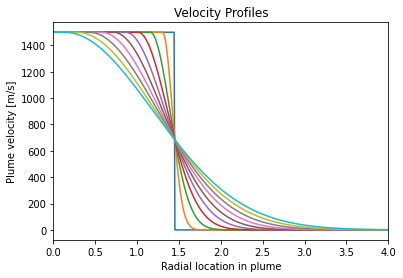

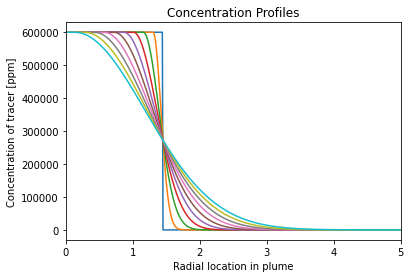

In [4]:
#Plots
#plot_diffusion(T,r,nx,xmax,'Figure 1')
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
ax1.set_title("Velocity Profiles")
ax2.set_title("Concentration Profiles")
ax1.set_xlabel("Radial location in plume")
ax2.set_xlabel("Radial location in plume")
ax1.set_ylabel("Plume velocity [m/s]")
ax2.set_ylabel("Concentration of tracer [ppm]")
ax1.set_xlim(0,4)
ax2.set_xlim(0,5)

for i in range(0,nx_ZFE,10):
    ax1.plot(r_ZFE[i,:],u[i,:])
    ax2.plot(r_ZFE[i,:],c[i,:])

#checking that concentration is conserved of tracer
print(np.trapz(c[1,:]))
print(np.trapz(c[99,:]))

In [5]:
#ZEF
U0 = u[nx_ZFE-1,0] #centerline velocity at end of ZFE
C0 = c[nx_ZFE-1,0]
A0 = np.pi*(D/2)**2
Q0 = (U0+U_a)*A0
T_a = 400 #K replace must import

lmbda = 1.35
B0 = D/2 #initial plume radius
M_e = np.pi*B0**2 *U0*(U0-U_a)
lm_star = np.sqrt(np.sqrt(M_e)/U_a)
beta_s = 0.154

B_star = np.zeros(nx_ZEF)
U_star = np.zeros(nx_ZEF)
U_star[0] = (U0-U_a)/U_a

B_star[0] = np.sqrt((np.pi*(U_star[0]**2 + U_star[0]))**(-1)) #estimated initial plume width

x = np.linspace(0, xmax, nx_ZEF+nx_ZFE)
x1 = np.linspace(xmax_ZFE,xmax_ZEF,nx_ZEF)

#Solve for B*(x)
sol =  sp.integrate.solve_ivp(dBdx,[xmax_ZFE,xmax_ZEF], [B_star[0]], method='RK45', t_eval=x1)

for i in range(0,nx_ZEF):
    U_star[i] = abs((-1 + np.sqrt(1 - 4*(1/(-np.pi*sol.y[0,i]**2))))/2)

#reformat and save specific solution variables
B_star = sol.y[0,:]
x_ZEF = sol.t

1500.0
2.5046728971962615
0.190425809502177
0.190425809502177
2.5046728971962615
1500.0


In [13]:
#Compute B(x), U(x), C(x)
C0 = c[nx_ZFE-1,0]
B = np.zeros(nx_ZEF)
U = np.zeros(nx_ZEF)
Sc = np.zeros(nx_ZEF)
C_m = np.zeros(nx_ZEF)
rmax_ZEF = 100
r_ZEF = np.zeros((nx_ZEF,nr))
k = 0.174

for i in range(0,nx_ZEF):
    r_ZEF[i,:] = np.linspace(0,rmax_ZEF,nr)

r_tot = np.concatenate((r_ZFE,r_ZEF))

for i in range(0,nx_ZEF):
    B[i] = B_star[i]*lm_star
    U[i] = U_star[i]*U_a + U_a
    
    Sc[i] = k*(x[i]-x[0])/lm_star +1
    C_m[i] = C0/Sc[i]
C_m[0] = C0

[1500.         1143.18852187  977.91079501  884.09683345  824.66859432
  784.16171016  754.98053458  733.16229999  716.48310075  703.48341941
  693.16610888  684.82710781  678.07687402  672.55424821  667.90796528
  663.91830245  660.47363782  657.55546645  655.21536205  653.15766982
  651.37169223  649.98654758  649.0381282   648.47442472  648.15723
  647.86134126  647.27602602  646.44988182  645.690024    645.09819153
  644.72337762  644.56346479  644.56587424  644.62725911  644.5928911
  644.28775858  643.86345694  643.47273437  643.1919652   643.06157531
  643.08670998  643.23744554  643.44850141  643.61871012  643.61081251
  643.36383368  643.0761626   642.8234315   642.65245249  642.58791991
  642.63268617  642.76783109  642.9525096   643.12367917  643.19592684
  643.07761354  642.87988935  642.68416034  642.52194961  642.41423844
  642.37158262  642.39419216  642.47194783  642.58435391  642.70045284
  642.77875402  642.76725597  642.65595468  642.53411465  642.41850821
  642.3195

In [15]:
#Compute T(x,r)
T_a = 400 #K
nT = 0.1

T,rT = diffusion(nx_ZEF+nx_ZFE, nx_ZEF+nr, xmax, rmax_ZEF, nT, T_a) #ADD ZFE element to fxn

#Compute u(x,r) and c(x,r)
sigma_u = np.zeros(nx_ZEF)
sigma_c = np.zeros(nx_ZEF)
miu_u = 0
miu_c = 0
guess = B

#i = x, j = r
sigma_ZEFu = np.zeros(nx_ZEF)
sigma_ZEFc = np.zeros(nx_ZEF)
u_ZEF0 = np.zeros(nx_ZEF)
c_ZEF0 = np.zeros(nx_ZEF)
u_ZEF0[0] = U0
c_ZEF0[0] = C0
print(C0)
print(C_m[1])
print(r_ZEF)

for i in range(nx_ZFE,nx_ZEF+nx_ZFE-1): #start at ZEF (ex. index 100 to index 200)
    sigma_ZEFu[i-nx_ZFE] = 2*(A_u)/(u_ZEF0[i-nx_ZEF]*np.sqrt(2*np.pi)) #WHERE FROM????
    sigma_ZEFc[i-nx_ZFE] = 2.35*(A_c)/(c_ZEF0[i-nx_ZEF]*np.sqrt(2*np.pi))
    for j in range(0,nr):
        u[i,j] = U[i-nx_ZFE]*np.exp((-0.5*(r_ZEF[i-nx_ZFE,j]-miu_u)**2)/(sigma_ZEFu[i-nx_ZFE]**2))
        c[i,j] = C_m[i-nx_ZFE]*np.exp((-0.5*(r_ZEF[i-nx_ZFE,j]-miu_c)**2)/(sigma_ZEFc[i-nx_ZFE]**2))
        
        if j == 0:
            u_ZEF0[i-nx_ZEF+1] = u[i,0]
            c_ZEF0[i-nx_ZEF+1] = c[i,0]
print(c_ZEF0[1])

600000.0
5257840.773410177
[[  0.          0.1001001   0.2002002 ...  99.7997998  99.8998999
  100.       ]
 [  0.          0.1001001   0.2002002 ...  99.7997998  99.8998999
  100.       ]
 [  0.          0.1001001   0.2002002 ...  99.7997998  99.8998999
  100.       ]
 ...
 [  0.          0.1001001   0.2002002 ...  99.7997998  99.8998999
  100.       ]
 [  0.          0.1001001   0.2002002 ...  99.7997998  99.8998999
  100.       ]
 [  0.          0.1001001   0.2002002 ...  99.7997998  99.8998999
  100.       ]]
600000.0


10212277.500000002
10211672.184402792


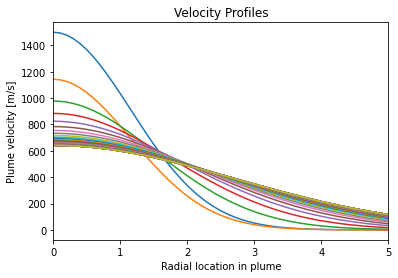

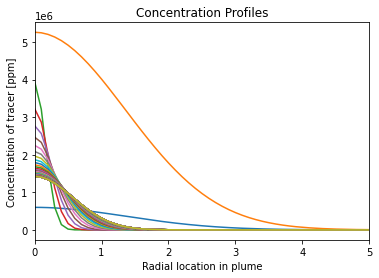

In [8]:
#Plots
#plot_diffusion(T,r,nx,xmax,'Figure 1')
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
ax1.set_title("Velocity Profiles")
ax2.set_title("Concentration Profiles")
ax1.set_xlabel("Radial location in plume")
ax2.set_xlabel("Radial location in plume")
ax1.set_ylabel("Plume velocity [m/s]")
ax2.set_ylabel("Concentration of tracer [ppm]")
ax1.set_xlim(0,15)
ax2.set_xlim(0,15)

for i in range(nx_ZFE,nx_ZFE+nx_ZEF-1):
    ax1.plot(r_ZEF[i-nx_ZFE,:],u[i,:])
    ax2.plot(r_ZEF[i-nx_ZFE,:],c[i,:])

#checking that concentration is conserved of tracer
print(np.trapz(c[nx_ZFE,:]))
print(np.trapz(c[nx_ZFE+nx_ZEF-2,:]))

In [9]:
#Adding Cantera

#check that moles consreved with tracer



In [10]:
def solve_reaction(X, T, P, x_1, x_2, u_1, u_2, gas, j, n_species):

    reactor = ct.IdealGasConstPressureReactor(gas)

    #FOR NO REACTIONS
    #gas.set_multiplier(0)

    states = ct.SolutionArray(gas)
    X_new = np.zeros_like(X)

    for i in range(1,np.size(X[:, 1])): #index through all "r"s

        try:
            gas.TPX = T[i], P, X[i, :] #X[r value, species index]
        except:
            print(i)
            print(gas.report())

        reactor.syncState()
        reactorNet = ct.ReactorNet([reactor])
        t_final = u

        reactorNet.advance(t_final, apply_limit=false)
        
        states.append(reactor.thermo.state)

        #save new composition for that r position
        X_new[i, :] = 10**6 * reactor.thermo.X #mole fraction to ppm state.X[len,:] 10^9 #kmol/m^3s, assume 1 m^3, to ppm #rates for specific y (i) and all species UNITS

    return X_new, states #for all y and all species [s,n_species]